In [3]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import numpy as np
import glob

dataset_path = r'c:\Users\asuka\Downloads\archive\House_Room_Dataset'
categories = ['Bathroom', 'Bedroom', 'Dinning', 'Kitchen', 'Livingroom']
IMAGE_SIZE = (128, 128)
batch_size = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Function to load and preprocess images with center cropping
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.central_crop(image, central_fraction=0.8)  # Center crop the image
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

image_paths = []
labels = []
label_map = {category: idx for idx, category in enumerate(categories)}

for category in categories:
    category_files = glob.glob(os.path.join(dataset_path, category, '*.jpg')) + glob.glob(os.path.join(dataset_path, category, '*.png'))
    image_paths.extend(category_files)
    labels.extend([label_map[category]] * len(category_files))

train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, labels, test_size=0.3, stratify=labels, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

print(f'Total images: {len(image_paths)}')
print(f'Training set size: {len(train_paths)}')
print(f'Validation set size: {len(val_paths)}')
print(f'Test set size: {len(test_paths)}')

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# Augmentation operations
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def apply_augmentation(image, label):
    return data_augmentation(image, training=True), label

# Apply augmentation to the training dataset
train_ds = train_ds.map(apply_augmentation, num_parallel_calls=AUTOTUNE)

Total images: 5250
Training set size: 3675
Validation set size: 787
Test set size: 788


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_mobilenetv2_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
    
    # Unfreeze layers for fine-tuning
    for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x) 
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

num_classes = len(categories)

# Create and compile the MobileNetV2 model
model = create_mobilenetv2_model(input_shape=(*IMAGE_SIZE, 3), num_classes=num_classes)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\asuka\AppData\Local\Temp\ipykernel_17396\1591507642.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model_mobilenetv2_house_rooms.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train model
history = model.fit(
    train_ds,
    epochs=50,  
    validation_data=val_ds,
    callbacks=[checkpoint]
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step - accuracy: 0.2275 - loss: 1.9572 - val_accuracy: 0.2745 - val_loss: 1.8463
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.4137 - loss: 1.3964 - val_accuracy: 0.3050 - val_loss: 1.9142
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.5352 - loss: 1.1664 - val_accuracy: 0.3291 - val_loss: 2.1658
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.6023 - loss: 1.0054 - val_accuracy: 0.3545 - val_loss: 2.3289
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.6557 - loss: 0.9012 - val_accuracy: 0.3647 - val_loss: 2.4895
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.6946 - loss: 0.8061 - val_accuracy: 0.4028 - val_loss: 2.5202
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.7105 - loss: 0.7557 - val_accuracy: 0.4206 - val_loss: 2.4605
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.7330 - loss: 0.6964 - val_accuracy: 0.4524 - val_loss

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 759ms/step - accuracy: 0.1746 - loss: 2.3673
Test Accuracy: 17.89%
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1559 - loss: 2.1954
Train Accuracy: 16.08%
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
Top-1 Accuracy: 17.89%
Top-5 Accuracy: 100.00%
Top-10 Accuracy: 100.00%


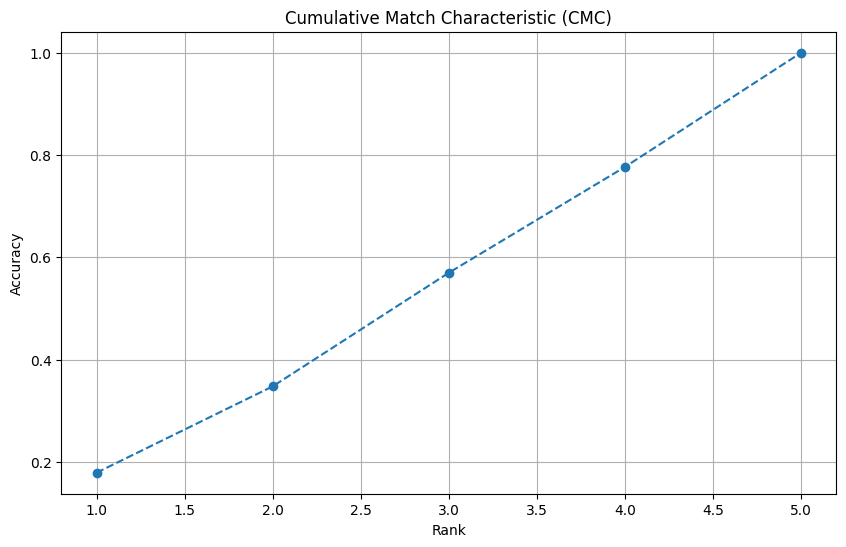

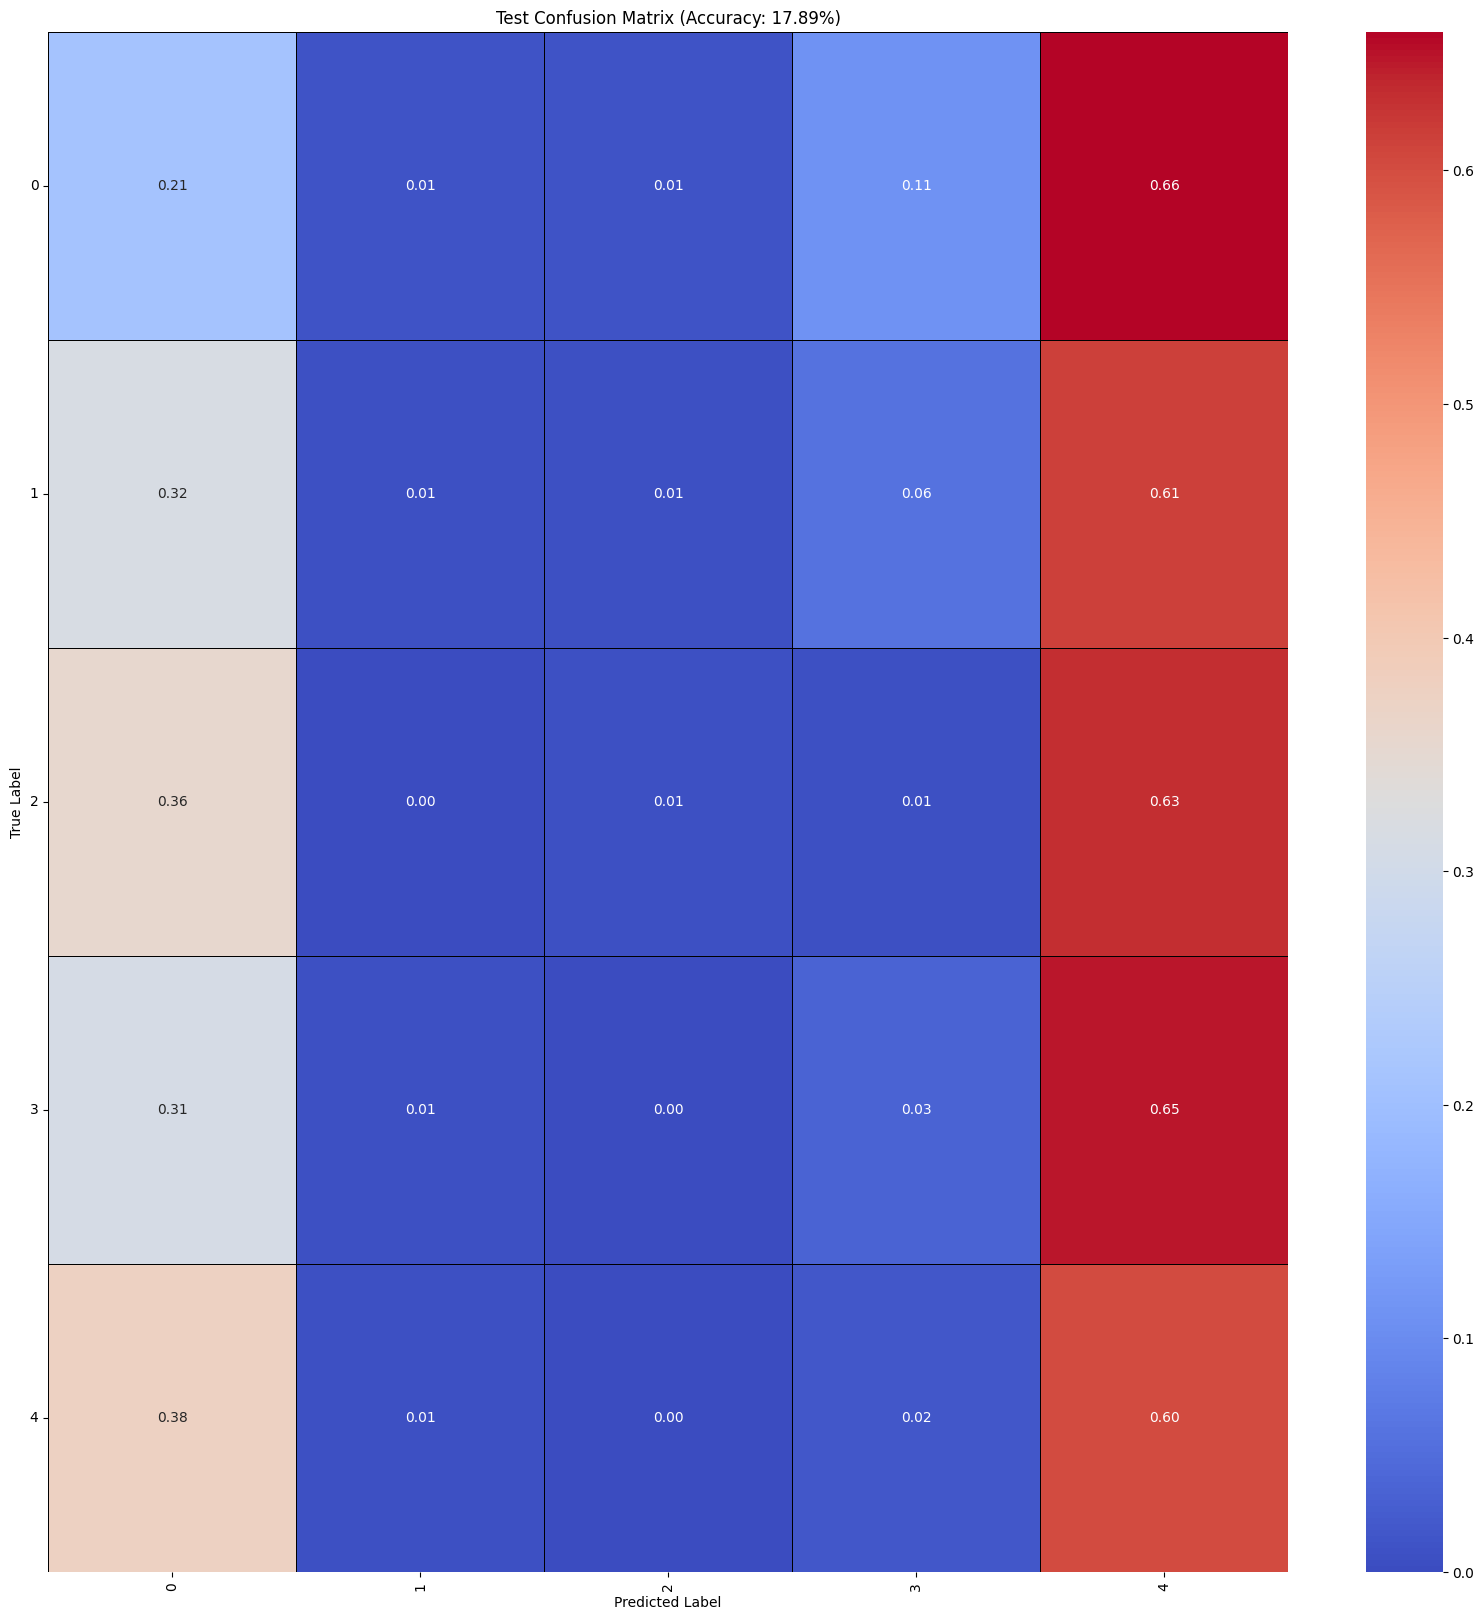

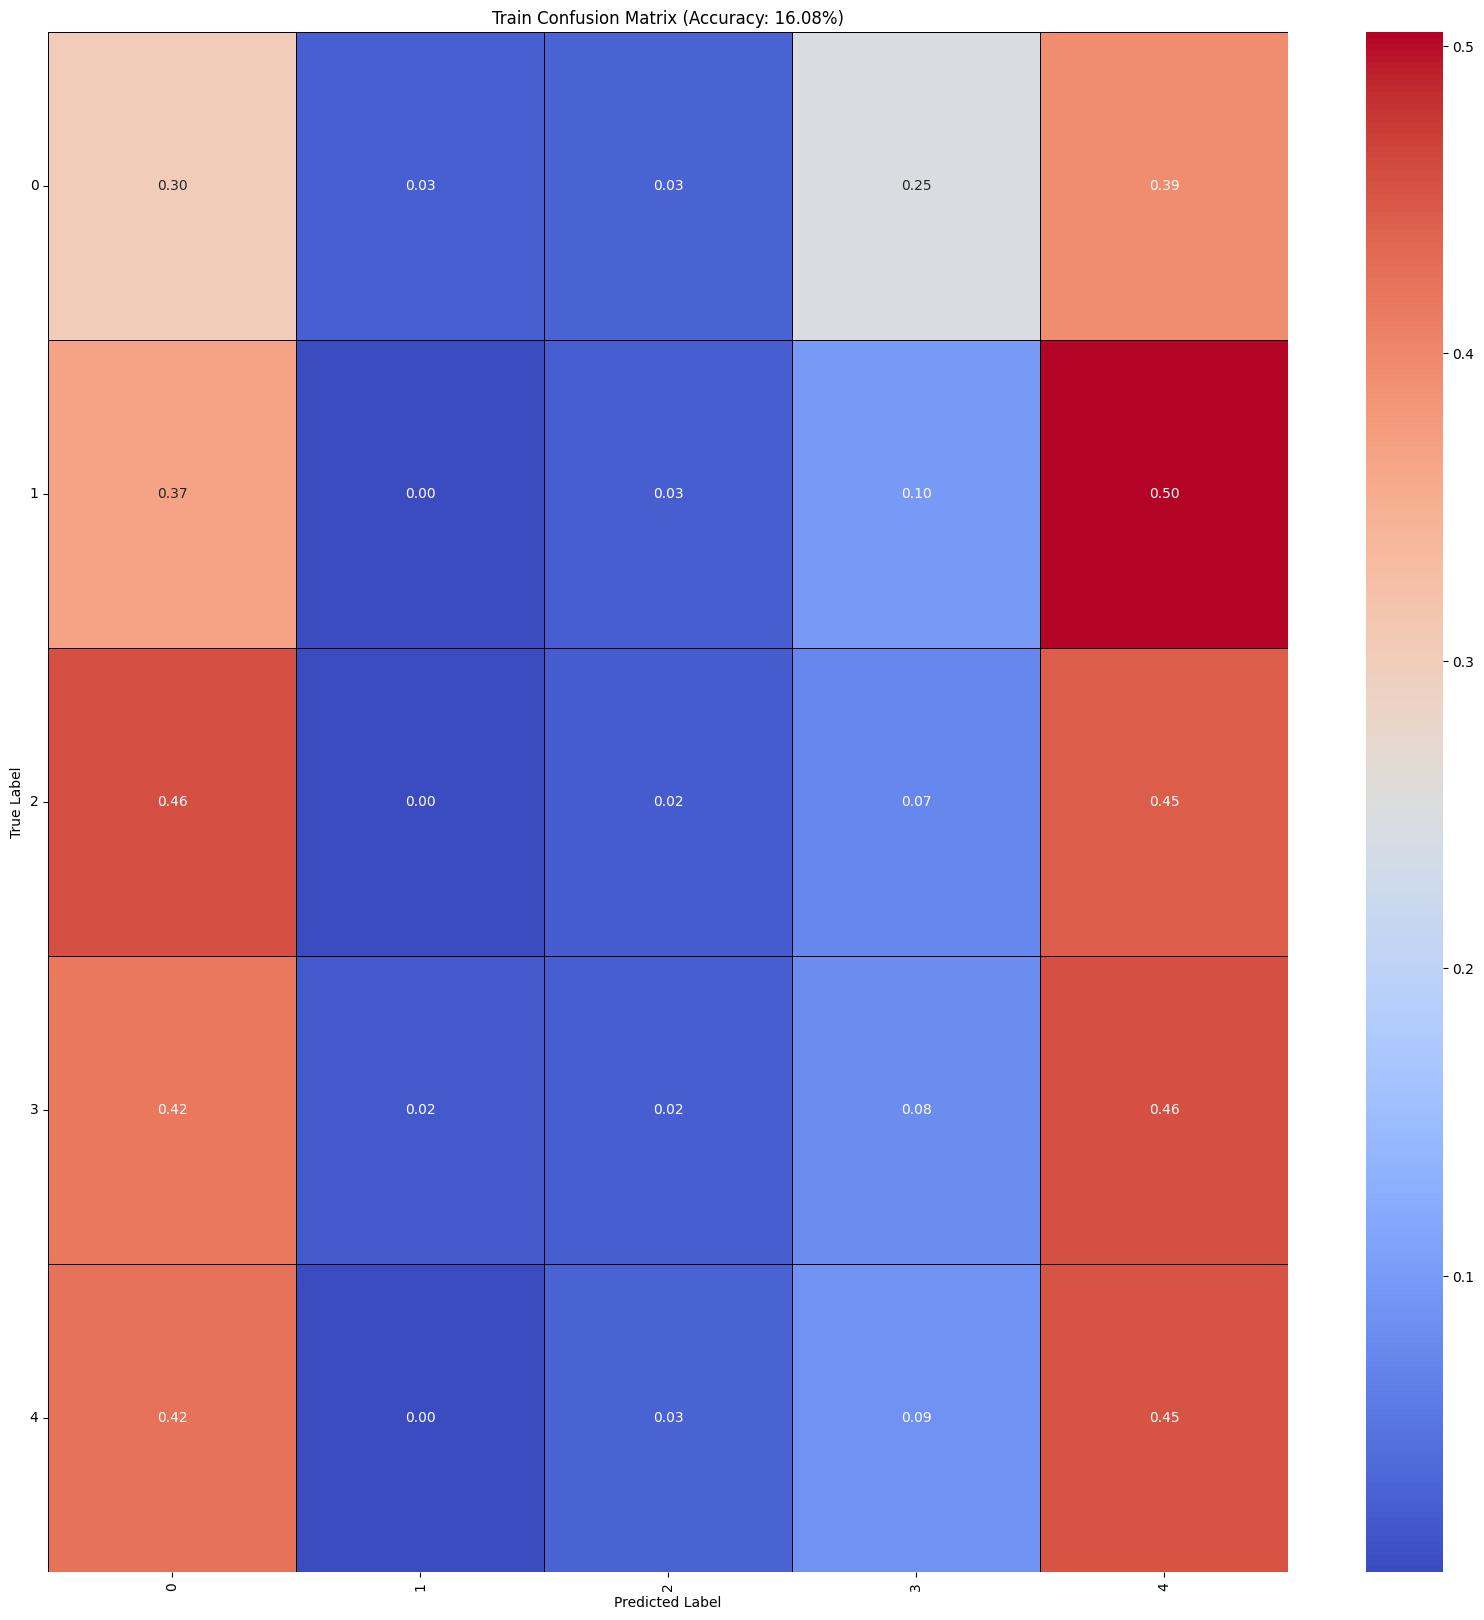

              precision    recall  f1-score   support

           0       0.07      0.21      0.11        91
           1       0.25      0.01      0.01       187
           2       0.33      0.01      0.01       174
           3       0.17      0.03      0.06       145
           4       0.23      0.60      0.34       191

    accuracy                           0.18       788
   macro avg       0.21      0.17      0.10       788
weighted avg       0.23      0.18      0.11       788



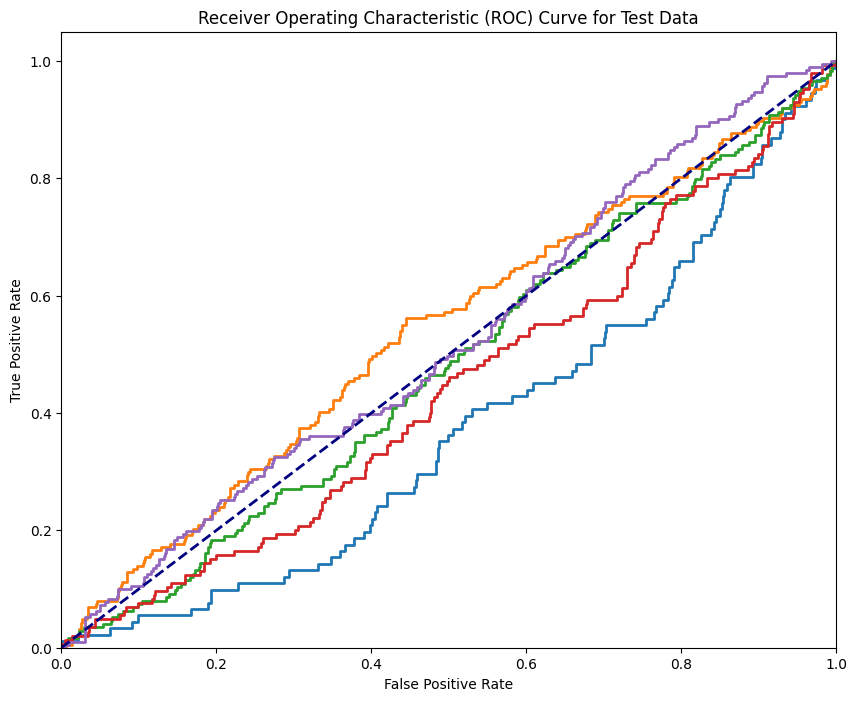

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
import seaborn as sns
import tensorflow as tf
import matplotlib.colors as mcolors

# Function to compute top-k accuracy
def top_k_accuracy(y_true, y_pred, k=1):
    top_k_predictions = np.argsort(y_pred, axis=1)[:, -k:]
    matches = np.any(top_k_predictions.T == y_true, axis=0)
    return np.mean(matches)

# Function to plot Cumulative Match Characteristic (CMC)
def plot_cmc(y_true, y_pred, num_classes):
    cmc = np.zeros(num_classes)
    for i in range(1, num_classes + 1):
        cmc[i-1] = top_k_accuracy(y_true, y_pred, k=i)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_classes + 1), cmc, marker='o', linestyle='--')
    plt.xlabel('Rank')
    plt.ylabel('Accuracy')
    plt.title('Cumulative Match Characteristic (CMC)')
    plt.grid()
    plt.show()

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Evaluate on train data
train_loss, train_acc = model.evaluate(train_ds)
print(f"Train Accuracy: {train_acc * 100:.2f}%")

# Generate predictions and true labels for the test data
test_predictions = model.predict(test_ds)
test_predicted_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.concatenate([y for x, y in test_ds], axis=0)

# Generate predictions and true labels for the train data
train_predictions = model.predict(train_ds)
train_predicted_classes = np.argmax(train_predictions, axis=1)
train_true_classes = np.concatenate([y for x, y in train_ds], axis=0)

# Ensure predictions are probabilities
if np.max(test_predictions) > 1 or np.min(test_predictions) < 0 or not np.allclose(np.sum(test_predictions, axis=1), 1):
    test_predictions = tf.nn.softmax(test_predictions).numpy()
if np.max(train_predictions) > 1 or np.min(train_predictions) < 0 or not np.allclose(np.sum(train_predictions, axis=1), 1):
    train_predictions = tf.nn.softmax(train_predictions).numpy()

# Calculate top-1, top-5, and top-10 accuracy for test data
top_1_acc = top_k_accuracy(test_true_classes, test_predictions, k=1)
top_5_acc = top_k_accuracy(test_true_classes, test_predictions, k=5)
top_10_acc = top_k_accuracy(test_true_classes, test_predictions, k=10)

print(f"Top-1 Accuracy: {top_1_acc * 100:.2f}%")
print(f"Top-5 Accuracy: {top_5_acc * 100:.2f}%")
print(f"Top-10 Accuracy: {top_10_acc * 100:.2f}%")

# Plot CMC for test data
plot_cmc(test_true_classes, test_predictions, num_classes)

# Generate confusion matrix for test data
test_cm = confusion_matrix(test_true_classes, test_predicted_classes)

# Generate confusion matrix for train data
train_cm = confusion_matrix(train_true_classes, train_predicted_classes)

# Normalize confusion matrices
test_cm_normalized = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]
train_cm_normalized = train_cm.astype('float') / train_cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix for test data
plt.figure(figsize=(20, 20))
sns.heatmap(test_cm_normalized, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Test Confusion Matrix (Accuracy: {test_acc * 100:.2f}%)')
plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=np.arange(num_classes), rotation=90)
plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=np.arange(num_classes), rotation=0)
plt.show()

# Plot normalized confusion matrix for train data
plt.figure(figsize=(20, 20))
sns.heatmap(train_cm_normalized, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Train Confusion Matrix (Accuracy: {train_acc * 100:.2f}%)')
plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=np.arange(num_classes), rotation=90)
plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=np.arange(num_classes), rotation=0)
plt.show()

# Print classification report for test data
print(classification_report(test_true_classes, test_predicted_classes))

# AUC ROC for test data
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_true_classes == i, test_predictions[:, i])
    roc_auc[i] = roc_auc_score(test_true_classes == i, test_predictions[:, i])

# Plot ROC curve without legend for test data
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test Data')
plt.show()



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions and true labels for the test data
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.concatenate([y for x, y in test_ds], axis=0)

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Calculate the most misclassified labels
def most_misclassified(cm, n=5):
    # Set the diagonal to zero to ignore true positives
    np.fill_diagonal(cm, 0)
    # Flatten the confusion matrix and get the indices of the largest values
    misclassified_indices = np.unravel_index(np.argsort(cm, axis=None)[-n:], cm.shape)
    # Get the misclassified labels
    misclassified_labels = [(i, j, cm[i, j]) for i, j in zip(misclassified_indices[0], misclassified_indices[1])]
    # Sort by the number of misclassifications
    misclassified_labels = sorted(misclassified_labels, key=lambda x: x[2], reverse=True)
    return misclassified_labels

# Display the most misclassified labels
def display_misclassified_labels(misclassified_labels, class_names):
    for i, (true_label, pred_label, count) in enumerate(misclassified_labels):
        print(f"Rank {i+1}: True label '{class_names[true_label]}' misclassified as '{class_names[pred_label]}' ({count} times)")

# Get class names from metadata
class_names = metadata.features['label'].names

# Get the top 5 most misclassified labels
misclassified_labels = most_misclassified(cm, n=15)

# Display the most misclassified labels
display_misclassified_labels(misclassified_labels, class_names)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 788ms/step


NameError: name 'metadata' is not defined